In [34]:
#imports
import numpy as np
import pandas as pd
import scipy.optimize as spo
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.linalg import inv
from math import log, sqrt
import warnings


In [35]:
#initialize variables
probability_ranges = []
simulations = None
description = ""

warnings.filterwarnings("ignore", category=RuntimeWarning)



<div style="background-color: #333333; color: #FFDD57; padding: 15px; border-radius: 10px; border: 2px solid #FFDD57;">
    <h2 style="margin: 0; font-size: 24px;">Exercise 3</h2>
    <p>Optimization of sharpe ratio and volatility (GMVP) and provides results such as return, volatility and weights</p>
</div>


In [36]:
# Load data from Excel file
file_path = 'prices_import.xlsx'  # Adjust this path if necessary
df = pd.read_excel(file_path)
prices = df.values  # Extract the price data as a numpy array
print(df)

       GE   MSFT    JNJ      K     BA    IBM
0    2.36   2.68   6.78  20.37   2.34  11.79
1    4.15   2.64   7.20  18.47   4.21  14.62
2    4.98   3.68  10.91  19.90   4.20  15.53
3    8.80   5.73  19.43  29.03   8.09  20.41
4   13.51  12.64  24.44  27.59  13.93  30.78
5   21.64  18.49  29.15  38.01  20.19  31.60
6   30.57  43.37  38.04  34.14  23.47  30.94
7   40.51  48.51  39.36  20.93  36.27  39.24
8   42.42  30.26  43.80  23.52  48.13  48.78
9   34.82  31.58  55.19  28.70  41.39  51.05
10  22.25  23.52  52.15  32.00  32.81  59.63
11  31.86  28.16  51.49  37.36  48.86  81.95


/Users/alexandrekobrin/Desktop/test AFE/.venv/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


<div style="background-color: #444444; color: #FFC966; padding: 8px; border-radius: 6px; border: 1.5px solid #FFC966;">
    <h4 style="margin: 0; font-size: 18px;">Assumptions </h4>
    <p style="font-size: 14px; margin: 5px 0 0;">We set the assumptions of the exercise.</p>
</div>

In [37]:
# --- Financial Assumptions and Portfolio Constraints ---

# 1. Risk-free rate of return (constant for Sharpe Ratio calculations)
risk_free_rate = 0  # Constant 1% as specified in the question

# 2. Short positions allowed?
short_positions_allowed = False  # Set to True if shorting is permitted

# 3. Maximum short position (if shorting is allowed)
max_short_position = 0 if short_positions_allowed else 0  # 5% if shorting allowed

# 4. Maximum position constraint
use_max_position_constraint = True
max_position_per_asset = 0.4 if use_max_position_constraint else 1  # Set based on question requirements

# 5. Minimum position constraint for diversification
use_min_position_constraint = True
min_position_per_asset = 0 if use_min_position_constraint else 0  # Set based on question requirements

# --- Data Calculations (based on input data) ---

# Calculate log returns from price data (assuming `prices` is a numpy array of historical prices)
log_returns = np.log(prices[1:] / prices[:-1])  # Calculate log returns for each period (row-wise)
expected_returns = np.mean(log_returns, axis=0)  # Average return for each asset across all periods

# Covariance matrix of returns
max_observations = log_returns.shape[0]  # Number of return observations
cov_matrix = (log_returns - expected_returns).T @ (log_returns - expected_returns) / max_observations

# Number of assets and initial weights
num_assets = len(expected_returns)
initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights as an initial guess

# --- Constraints Setup ---

# Define a base constraint that requires the sum of weights to equal 1 (100% allocation)
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]

# Only apply a maximum position constraint if it's specified and no other constraints are required
# This conditional setup uses only a max constraint if specified, aligning with the solution's approach.
if use_max_position_constraint and not use_min_position_constraint:
    constraints.append({'type': 'ineq', 'fun': lambda weights: max_position_per_asset - weights})
else:
    # Apply minimum position constraint if `use_min_position_constraint` is True
    if use_min_position_constraint:
        constraints.append({'type': 'ineq', 'fun': lambda weights: weights - (max_short_position if short_positions_allowed else min_position_per_asset)})

    # Apply maximum position constraint if `use_max_position_constraint` is True
    if use_max_position_constraint:
        constraints.append({'type': 'ineq', 'fun': lambda weights: max_position_per_asset - weights})

<div style="background-color: #444444; color: #FFC966; padding: 8px; border-radius: 6px; border: 1.5px solid #FFC966;">
    <h4 style="margin: 0; font-size: 18px;">Optimization function 1</h4>
    <p style="font-size: 14px; margin: 5px 0 0;">Optimal sharpe ratio</p>
</div>

In [38]:
# Objective function: Sharpe Ratio (maximizing sharp ratio)
def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    """
    Calculate the negative Sharpe Ratio for a given portfolio weight distribution.
    
    Parameters:
    - weights: Portfolio weights for each asset.
    - expected_returns: Expected returns of each asset.
    - cov_matrix: Covariance matrix of returns.
    - risk_free_rate: Risk-free rate of return.
    
    Returns:
    - Negative Sharpe Ratio.
    """
    portfolio_return = np.dot(weights, expected_returns)  # Portfolio expected return
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))  # Portfolio variance
    portfolio_volatility = sqrt(portfolio_variance)  # Portfolio volatility (standard deviation)
    return -(portfolio_return - risk_free_rate) / portfolio_volatility  # Negative Sharpe Ratio

# Perform the optimization to find optimal weights for maximum Sharpe Ratio
result = spo.minimize(
    negative_sharpe_ratio,           # Objective function
    initial_weights,                 # Initial guess for weights
    args=(expected_returns, cov_matrix, risk_free_rate),  # Extra arguments for the objective function
    method='SLSQP',                  # Optimization method
    constraints=constraints          # Constraints for weights
)

# Extract the optimized weights and Sharpe Ratio
optimized_weights = np.round(result.x, 5)  # Optimal weights for maximum Sharpe Ratio
optimal_sharpe_ratio = -negative_sharpe_ratio(result.x, expected_returns, cov_matrix, risk_free_rate)  # Optimal Sharpe Ratio

# Output results
print("Optimal Weights:", optimized_weights)
print("Optimal Sharpe Ratio:", round(optimal_sharpe_ratio, 4))


Optimal Weights: [0.      0.00125 0.4     0.073   0.12575 0.4    ]
Optimal Sharpe Ratio: 1.6622


In [39]:
# Calculate the expected return of the efficient portfolio using the optimized weights
efficient_portfolio_return = np.dot(optimized_weights, expected_returns)

# Output the result
print("Expected Return of the Efficient Portfolio:", round(efficient_portfolio_return, 4))

Expected Return of the Efficient Portfolio: 0.1833


In [40]:
# Display the weights of the efficient portfolio (from the optimization result)
print("Weights of the Efficient Portfolio:", np.round(optimized_weights, 4))

Weights of the Efficient Portfolio: [0.     0.0012 0.4    0.073  0.1258 0.4   ]


In [41]:
# Calculate the volatility of the previously optimized efficient portfolio (from Sharpe Ratio maximization)
efficient_portfolio_volatility = sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))

# Output the result
print("Volatility of the Efficient Portfolio:", round(efficient_portfolio_volatility, 4))


Volatility of the Efficient Portfolio: 0.1102


<div style="background-color: #444444; color: #FFC966; padding: 8px; border-radius: 6px; border: 1.5px solid #FFC966;">
    <h4 style="margin: 0; font-size: 18px;">Optimization function 2</h4>
    <p style="font-size: 14px; margin: 5px 0 0;">GMVP</p>
</div>

In [42]:
# Objective function to minimize portfolio volatility for GMVP
def portfolio_volatility(weights, cov_matrix):
    """
    Calculate the portfolio volatility (standard deviation) for a given set of weights.

    Parameters:
    - weights: Portfolio weights for each asset.
    - cov_matrix: Covariance matrix of returns.

    Returns:
    - Portfolio volatility.
    """
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))  # Portfolio variance
    return sqrt(portfolio_variance)  # Portfolio volatility (standard deviation)

# Perform the optimization to find the GMVP (Global Minimum Variance Portfolio)
result_gmvp = spo.minimize(
    portfolio_volatility,            # Objective function to minimize volatility
    initial_weights,                 # Initial guess for weights
    args=(cov_matrix,),              # Only covariance matrix is needed for volatility calculation
    method='SLSQP',                  # Optimization method
    constraints=constraints          # Reuse the constraints for shorting and max weight of 30%
)

# Extract the optimized weights and GMVP volatility
optimized_weights_gmvp = np.round(result_gmvp.x, 5)  # Weights for GMVP
gmvp_volatility = portfolio_volatility(result_gmvp.x, cov_matrix)  # Minimum volatility (GMVP)

# Output results
print("Optimal Weights for GMVP:", optimized_weights_gmvp)
print("Volatility of the GMVP Portfolio:", round(gmvp_volatility, 4))


Optimal Weights for GMVP: [-0.       0.00829  0.35774  0.19774  0.03623  0.4    ]
Volatility of the GMVP Portfolio: 0.1032


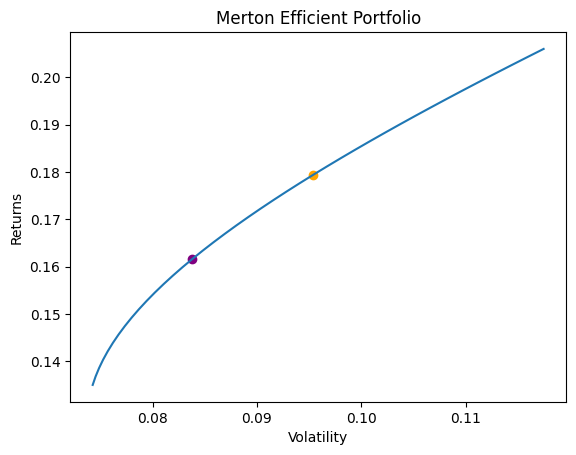

In [43]:
#Emile's template

# Load data
smat = df.values

# Calculate returns
ret1 = np.log(smat[1:, :] / smat[:-1, :])

# Expected returns, variance, and standard deviation
er = np.mean(ret1, axis=0)
var = np.var(ret1, axis=0)
std = np.sqrt(var)

# Covariance matrix
count = np.shape(ret1)[0]
s = (ret1 - er).T @ (ret1 - er) / count

# Portfolio optimization for c1
c1 = 0.01  # Change this value as needed
w1 = (inv(s) @ (er - c1)) / np.sum(inv(s) @ (er - c1))
er1 = w1.T @ er
var1 = w1.T @ s @ w1
vol1 = np.sqrt(var1)

# Portfolio optimization for c2
c2 = 0.05  # Change this value as needed
w2 = (inv(s) @ (er - c2)) / np.sum(inv(s) @ (er - c2))
er2 = w2.T @ er
var2 = w2.T @ s @ w2
vol2 = np.sqrt(var2)

# Efficient Frontier and plot
𝜆 = np.arange(-1.5, 2.6, 0.1)
volp = np.sqrt(𝜆**2 * var1 + (1 - 𝜆)**2 * var2 + 2 * 𝜆 * (1 - 𝜆) * (w1.T @ s @ w2))
erp = 𝜆 * er1 + (1 - 𝜆) * er2

# Plot Efficient Portfolio
plt.title("Merton Efficient Portfolio")
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.scatter(vol1, er1, color='purple')
plt.scatter(vol2, er2, color='orange')
plt.plot(volp, erp)


# Minimization for Sharpe ratio
def f_negative_sharpe(w, er, s, r):
    er_p = er.T @ w
    var_p = (w.T @ s) @ w
    vol_p = np.sqrt(var_p)
    return -(er_p - r) / vol_p

# Initial weights
w0 = [1, 0, 0.5, 1, 1, 1]

# Example optimization with initial guess and constraints
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: w})
optimize_result = spo.minimize(f_negative_sharpe, w0, args=(er, s, c1), constraints=cons)
optimized_weights = optimize_result.x

<div style="background-color: #333333; color: #FFDD57; padding: 15px; border-radius: 10px; border: 2px solid #FFDD57;">
    <h2 style="margin: 0; font-size: 24px;">Exercise 4</h2>
    <p>Option pricing and bond default.</p>
</div>


<div style="background-color: #444444; color: #FFC966; padding: 8px; border-radius: 6px; border: 1.5px solid #FFC966;">
    <h4 style="margin: 0; font-size: 18px;">Assumptions </h4>
    <p style="font-size: 14px; margin: 5px 0 0;">We set the assumptions of the exercise.</p>
</div>

In [44]:
# --- Assumptions and Parameters ---

# General simulation settings
iterations = 100,000  # Number of Monte Carlo simulations

# Select Distribution Type: 'uniform', 'normal', 'exponential'
distribution_type = 'exponential'  # Change based on question requirements

# Parameters for each distribution type
# Uniform Distribution (for questions with uniform recovery values)
uniform_min = 0.0             # Minimum value for Uniform distribution
uniform_max = 0.8             # Maximum value for Uniform distribution

# Normal Distribution (for questions with stock returns following normal distribution)
normal_mean = 0.06            # Mean (expected return)
normal_sigma = 0.25           # Standard deviation (volatility)

# Exponential Distribution (for questions with exponential time to default)
exponential_lambda = 1/12   # Lambda (rate parameter)

# Context for probability queries: "percent" for percentage-based, "years" for time-based
query_context = "years"  # Options: "percent" for recovery rates, "years" for time to default

# Define Probability Queries based on the context
# Format: (lower_bound, upper_bound, condition)
# Adjust these ranges based on the specific question requirements

if query_context == "percent":
    probability_ranges = [
        (0.2, 0.3, 'within'),  # Probability that R is between 20% and 30%
        (None, 0.4, 'lower'),  # Probability that R is lower than 40%
        (0.1, 0.7, 'or')       # Probability that R is lower than 10% or higher than 70%
    ]
elif query_context == "years":
    probability_ranges = [
        (5, 8, 'within'),     # Probability that time to default is between 3 and 30 years
        (None, 3, 'lower'),    # Probability that time to default is lower than 3 years
        (10, None, 'higher')   # Probability that time to default is higher than 10 years
    ]


<div style="background-color: #444444; color: #FFC966; padding: 8px; border-radius: 6px; border: 1.5px solid #FFC966;">
    <h4 style="margin: 0; font-size: 18px;">Monte Carlo Simulation</h4>
    <p style="font-size: 14px; margin: 5px 0 0;">Simulate the given distribution and calculate probabilities.</p>

In [45]:

def simulate_uniform(iterations, min_val, max_val):
    """Simulate values from a Uniform distribution."""
    return np.random.uniform(min_val, max_val, iterations)

def simulate_normal(iterations, mean, sigma):
    """Simulate values from a Normal distribution."""
    return np.random.normal(mean, sigma, iterations)

def simulate_exponential(iterations, lam):
    """Simulate values from an Exponential distribution."""
    return np.random.exponential(1 / lam, iterations)


<div style="background-color: #444444; color: #FFC966; padding: 8px; border-radius: 6px; border: 1.5px solid #FFC966;">
    <h4 style="margin: 0; font-size: 18px;">Computation Functions</h4>
    <p style="font-size: 14px; margin: 5px 0 0;">These functions handle probability calculations and option pricing, adapting based on the input parameters.</p>

In [46]:
def calculate_probability(simulations, lower=None, upper=None, condition='within'):
    """
    Calculate the probability based on the specified condition.
    
    Parameters:
    - simulations: Array of simulated values.
    - lower: Lower bound for the probability calculation.
    - upper: Upper bound for the probability calculation.
    - condition: The condition type ('within', 'lower', 'higher', 'or').
    
    Returns:
    - Probability that values meet the specified condition.
    """
    if condition == 'within' and lower is not None and upper is not None:
        # Probability within [lower, upper] range
        return np.mean((simulations >= lower) & (simulations <= upper))
    elif condition == 'lower' and upper is not None:
        # Probability below upper bound
        return np.mean(simulations <= upper)
    elif condition == 'higher' and lower is not None:
        # Probability above lower bound
        return np.mean(simulations >= lower)
    elif condition == 'or' and lower is not None and upper is not None:
        # Probability that values are below lower bound or above upper bound
        return np.mean((simulations < lower) | (simulations > upper))
    return 0.0


<div style="background-color: #444444; color: #FFC966; padding: 8px; border-radius: 6px; border: 1.5px solid #FFC966;">
    <h4 style="margin: 0; font-size: 18px;">Execution and Results Section</h4>
    <p style="font-size: 14px; margin: 5px 0 0;">This section uses the chosen assumptions to determine which distribution to simulate and computes the required probabilities and option prices.</p>

##### Execution and Results Guide

This section runs the simulation based on the **distribution type** and computes probabilities or option prices based on your assumptions.

1. **Run the Appropriate Simulation**
   - The code automatically selects the correct simulation based on `distribution_type`:
     - **'uniform'**: Uniform distribution (e.g., recovery values).
     - **'normal'**: Normal distribution (e.g., stock returns).
     - **'exponential'**: Exponential distribution (e.g., time to default).
     - **'gbm'**: Geometric Brownian Motion (GBM) for stock price simulations.

2. **Calculate Probabilities**
   - Uses `probability_ranges` to compute probabilities that values fall within specified intervals.
   - Example questions it can answer:
     - "What is the probability that the recovery rate is between 20% and 30%?"
     - "What is the probability that time to default is less than 5 years?"

3. **Additional Computations for GBM**
   - If `distribution_type = 'gbm'`, calculates:
     - Average stock price at maturity.
     - Probability that stock price is below a threshold.
     - European call/put option prices.
   - Example questions it can answer:
     - "What’s the average stock price at maturity?"
     - "What is the price of a European call option with a strike of $100?"

**Usage**: Adjust only the **Assumptions** section to match each question’s requirements, then run this cell to get all necessary results.


In [47]:
# --- Execution and Results ---

# Run the appropriate simulation based on distribution type
if distribution_type == 'uniform':
    simulations = simulate_uniform(iterations, uniform_min, uniform_max)
elif distribution_type == 'normal':
    simulations = simulate_normal(iterations, normal_mean, normal_sigma)
elif distribution_type == 'exponential':
    simulations = simulate_exponential(iterations, exponential_lambda)

# Calculate probabilities for specified ranges with descriptive output
print("Probability Results:")
for lower, upper, condition in probability_ranges:
    probability = calculate_probability(simulations, lower, upper, condition)

    # Construct descriptive message based on the context and condition type
    if query_context == "years":
        if condition == 'within':
            description = f"Probability that time to default is between {lower} and {upper} years"
        elif condition == 'lower':
            description = f"Probability that time to default is lower than {upper} years"
        elif condition == 'higher':
            description = f"Probability that time to default is higher than {lower} years"
    elif query_context == "percent":
        if condition == 'within':
            description = f"Probability that R is between {lower*100:.0f}% and {upper*100:.0f}%"
        elif condition == 'lower':
            description = f"Probability that R is lower than {upper*100:.0f}%"
        elif condition == 'higher':
            description = f"Probability that R is higher than {lower*100:.0f}%"
        elif condition == 'or':
            description = f"Probability that R is lower than {lower*100:.0f}% or higher than {upper*100:.0f}%"

    print(f"{description}: {round(probability, 4)}")


Probability Results:
Probability that time to default is between 5 and 8 years: nan
Probability that time to default is lower than 3 years: nan
Probability that time to default is higher than 10 years: nan


<div style="background-color: #444444; color: #FFC966; padding: 8px; border-radius: 6px; border: 1.5px solid #FFC966;">
    <h4 style="margin: 0; font-size: 18px;">CDF probability part</h4>
    <p style="font-size: 14px; margin: 5px 0 0;">Is a function that describes the probability that a random variable takes on a value less than or equal to a given point. Unlike Monte Carlo simulations, which generate random samples and estimate probabilities from them, the CDF allows us to calculate probabilities directly using the distribution's properties.</p>

In [48]:
from scipy.stats import uniform, norm, expon

# --- CDF Calculations for Probability Queries ---

print("CDF-based Probability Results:")

for lower, upper, condition in probability_ranges:
    probability = 0.0  # Default probability

    if distribution_type == 'uniform':
        # Uniform CDF-based calculations
        a, b = uniform_min, uniform_max
        if condition == 'within' and lower is not None and upper is not None:
            probability = uniform.cdf(upper, loc=a, scale=b - a) - uniform.cdf(lower, loc=a, scale=b - a)
        elif condition == 'lower' and upper is not None:
            probability = uniform.cdf(upper, loc=a, scale=b - a)
        elif condition == 'higher' and lower is not None:
            probability = 1 - uniform.cdf(lower, loc=a, scale=b - a)
        elif condition == 'or' and lower is not None and upper is not None:
            probability = uniform.cdf(lower, loc=a, scale=b - a) + (1 - uniform.cdf(upper, loc=a, scale=b - a))

    elif distribution_type == 'normal':
        # Normal CDF-based calculations
        mean, sigma = normal_mean, normal_sigma
        if condition == 'within' and lower is not None and upper is not None:
            probability = norm.cdf(upper, loc=mean, scale=sigma) - norm.cdf(lower, loc=mean, scale=sigma)
        elif condition == 'lower' and upper is not None:
            probability = norm.cdf(upper, loc=mean, scale=sigma)
        elif condition == 'higher' and lower is not None:
            probability = 1 - norm.cdf(lower, loc=mean, scale=sigma)
        elif condition == 'or' and lower is not None and upper is not None:
            probability = norm.cdf(lower, loc=mean, scale=sigma) + (1 - norm.cdf(upper, loc=mean, scale=sigma))

    elif distribution_type == 'exponential':
        # Exponential CDF-based calculations
        lambda_param = exponential_lambda
        if condition == 'within' and lower is not None and upper is not None:
            probability = expon.cdf(upper, scale=1/lambda_param) - expon.cdf(lower, scale=1/lambda_param)
        elif condition == 'lower' and upper is not None:
            probability = expon.cdf(upper, scale=1/lambda_param)
        elif condition == 'higher' and lower is not None:
            probability = 1 - expon.cdf(lower, scale=1/lambda_param)
        elif condition == 'or' and lower is not None and upper is not None:
            probability = expon.cdf(lower, scale=1/lambda_param) + (1 - expon.cdf(upper, scale=1/lambda_param))

    # Construct descriptive message (as in Monte Carlo)
    if condition == 'within':
        description = f"Probability that R is between {lower*100:.0f}% and {upper*100:.0f}%"
    elif condition == 'lower':
        description = f"Probability that R is lower than {upper*100:.0f}%"
    elif condition == 'higher':
        description = f"Probability that R is higher than {lower*100:.0f}%"
    elif condition == 'or':
        description = f"Probability that R is lower than {lower*100:.0f}% or higher than {upper*100:.0f}%"

    print(f"{description}: {round(probability, 4)}")


CDF-based Probability Results:
Probability that R is between 500% and 800%: 0.1458
Probability that R is lower than 300%: 0.2212
Probability that R is higher than 1000%: 0.4346


In [49]:
# --- Assumptions and Parameters for IBM Stock GBM Simulation ---

# General simulation settings
iterations = 1000  # Number of Monte Carlo simulations (N. Paths)
gbm_maturity = 5        # Maturity in years
gbm_initial_price = 60  # Initial stock price (S0)
gbm_drift = 0.10        # Drift rate (annualized return, mhu = r = 10%)
gbm_volatility = 0.30   # Volatility (annualized, 20%)
gbm_strike_price = 60  # Strike price for option pricing (K = 100, at the money)

# Parameters for Discounting
strike_price = 60  # Strike price (K)
maturity = gbm_maturity       # Time to maturity (T)
risk_free_rate = gbm_drift  # Assuming drift rate as the risk-free rate for discounting


# Probability Queries for Stock Price at Maturity
# Format: (lower_bound, upper_bound, condition)
# Conditions: 'lower' (below a price), 'higher' (above a price), 'exact' (at a price), 
# 'within' (within a range), 'or' (below a lower bound OR above an upper bound)
probability_queries = [
    (None, 100, 'lower'),        # Probability that stock price is below 100
    (150, None, 'higher'),       # Probability that stock price is above 150
    (200, 200, 'exact'),         # Probability that stock price is exactly 200
    (120, 180, 'within'),        # Probability that stock price is within [120, 180]
    (50, 200, 'or')              # Probability that stock price is below 50 or above 200
]

# Specify if you want to calculate probabilities and option prices
calculate_option_prices = True  # Set to True to price European call/put options
calculate_probability_below_threshold = 100  # Threshold for probability calculation (set to 100 for this exercise)


In [50]:
def calculate_probability(simulations, lower=None, upper=None, condition='within'):
    """
    Calculate the probability based on the specified condition.
    
    Parameters:
    - simulations: Array of simulated values.
    - lower: Lower bound for the probability calculation.
    - upper: Upper bound for the probability calculation.
    - condition: The condition type ('within', 'lower', 'higher', 'exact', 'or').
    
    Returns:
    - Probability that values meet the specified condition.
    """
    if condition == 'within' and lower is not None and upper is not None:
        # Probability within [lower, upper] range
        return np.mean((simulations >= lower) & (simulations <= upper))
    elif condition == 'lower' and upper is not None:
        # Probability below upper bound
        return np.mean(simulations < upper)
    elif condition == 'higher' and lower is not None:
        # Probability above lower bound
        return np.mean(simulations > lower)
    elif condition == 'exact' and lower == upper:
        # Probability that the value is exactly equal to a specified price
        return np.mean(simulations == lower)
    elif condition == 'or' and lower is not None and upper is not None:
        # Probability that values are below lower bound or above upper bound
        return np.mean((simulations < lower) | (simulations > upper))
    return 0.0


Sample of Stock Values at Maturity: [54.19125351 98.55413327 83.98105388 41.3849609  30.90980795 33.0753784
 70.24014892 84.52165867 73.10926437 40.70941263]


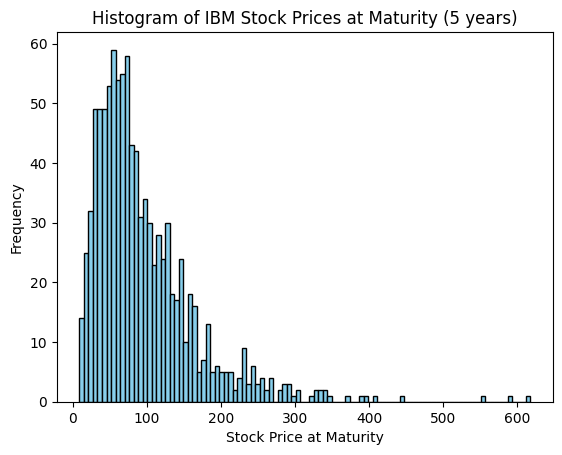

Average Stock Price at Maturity: 96.2246
European Call Option Price: 26.3042
European Put Option Price: 4.3329


In [51]:
# --- GBM Simulation for Stock Price at Maturity ---

def simulate_gbm(iterations, S0, drift, volatility, T):
    """
    Simulate stock prices at maturity using Geometric Brownian Motion.
    
    Parameters:
    - iterations: Number of simulation paths.
    - S0: Initial stock price.
    - drift: Drift rate (annualized return).
    - volatility: Volatility (annualized).
    - T: Time to maturity in years.
    
    Returns:
    - Array of simulated stock prices at maturity.
    """
    return S0 * np.exp((drift - 0.5 * volatility ** 2) * T + volatility * np.sqrt(T) * np.random.normal(0, 1, iterations))

# Run the GBM simulation
simulated_prices = simulate_gbm(iterations, gbm_initial_price, gbm_drift, gbm_volatility, gbm_maturity)

# 3.1 Output: Stock values at maturity
print("Sample of Stock Values at Maturity:", simulated_prices[:10])  # Print a sample of the output

# 3.2 Histogram of Stock Values at Maturity
plt.hist(simulated_prices, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Stock Price at Maturity")
plt.ylabel("Frequency")
plt.title("Histogram of IBM Stock Prices at Maturity (5 years)")
plt.show()

# 3.3 Average stock price at maturity
average_price = np.mean(simulated_prices)
print(f"Average Stock Price at Maturity: {round(average_price, 4)}")

"""# 3.4 Probability that IBM stock at maturity is below the threshold (100)
probability_below_threshold = np.mean(simulated_prices < calculate_probability_below_threshold)
print(f"Probability IBM Stock < {calculate_probability_below_threshold} at Maturity: {round(probability_below_threshold, 4)}")"""

# 3.5 Corrected European Call and Put Option Prices with Discounting
if calculate_option_prices:
    # Calculate Call and Put Payoffs with discounting
    call_payoffs = np.maximum(simulated_prices - strike_price, 0) * np.exp(-risk_free_rate * maturity)
    put_payoffs = np.maximum(strike_price - simulated_prices, 0) * np.exp(-risk_free_rate * maturity)
    
    # Calculate average (expected) option prices
    call_option_price = np.mean(call_payoffs)  # Call option price
    put_option_price = np.mean(put_payoffs)    # Put option price

    # Print results
    print(f"European Call Option Price: {round(call_option_price, 4)}")
    print(f"European Put Option Price: {round(put_option_price, 4)}")
    
    #calculate option premium

In [52]:
# --- Execution and Results ---

# Simulate stock prices at maturity using GBM
simulated_prices = simulate_gbm(iterations, gbm_initial_price, gbm_drift, gbm_volatility, gbm_maturity)

# Calculate probabilities for specified queries with descriptive output
print("Probability Results:")
for lower, upper, condition in probability_queries:
    probability = calculate_probability(simulated_prices, lower, upper, condition)

    # Construct descriptive message based on the condition type
    if condition == 'within':
        description = f"Probability that stock price is between {lower} and {upper}"
    elif condition == 'lower':
        description = f"Probability that stock price is below {upper}"
    elif condition == 'higher':
        description = f"Probability that stock price is above {lower}"
    elif condition == 'exact':
        description = f"Probability that stock price is exactly {lower}"
    elif condition == 'or':
        description = f"Probability that stock price is below {lower} or above {upper}"

    print(f"{description}: {round(probability, 4)}")


Probability Results:
Probability that stock price is below 100: 0.642
Probability that stock price is above 150: 0.16
Probability that stock price is exactly 200: 0.0
Probability that stock price is between 120 and 180: 0.155
Probability that stock price is below 50 or above 200: 0.319


<div style="background-color: #333333; color: #FFDD57; padding: 15px; border-radius: 10px; border: 2px solid #FFDD57;">
    <h2 style="margin: 0; font-size: 24px;">Other topics not covered in Exercises</h2>
    <p>Including Black Scholes and trees</p>
</div>


In [53]:
# Black-Scholes

# --- Assumptions (Adjust as Needed) ---
S = 60      # Current stock price
K = 45        # Strike price
T = 0.75      # Time to maturity (years)
r = 0.04      # Risk-free interest rate
sigma = 0.3   # Volatility (standard deviation of stock returns)

# --- Calculations ---

# Calculate d1 and d2
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

# Calculate call and put prices using Black-Scholes formula
call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
put_price = -S * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)

# Probabilities for d1 and d2 being less than or greater than a specified value (example: 1)
specified_value = 1
probability_d1_less_than_value = norm.cdf(specified_value, loc=d1)
probability_d1_greater_than_value = 1 - probability_d1_less_than_value
probability_d2_less_than_value = norm.cdf(specified_value, loc=d2)
probability_d2_greater_than_value = 1 - probability_d2_less_than_value

# Probability of the options expiring in-the-money
probability_in_the_money_call = norm.cdf(d2)  # For call option
probability_in_the_money_put = norm.cdf(-d2)  # For put option

# Probability of the options expiring out-of-the-money
probability_out_of_the_money_call = 1 - probability_in_the_money_call
probability_out_of_the_money_put = 1 - probability_in_the_money_put

# --- Outputs ---
print("d1:", round(d1, 4))
print("d2:", round(d2, 4))
print("European Call Option Price:", round(call_price, 4))
print("European Put Option Price:", round(put_price, 4))
print("Probability Call Option Expires In-The-Money:", round(probability_in_the_money_call, 4))
print("Probability Put Option Expires In-The-Money:", round(probability_in_the_money_put, 4))
print("Probability Call Option Expires Out-of-the-Money:", round(probability_out_of_the_money_call, 4))
print("Probability Put Option Expires Out-of-the-Money:", round(probability_out_of_the_money_put, 4))
print(f"Probability that d1 is less than {specified_value}:", round(probability_d1_less_than_value, 4))
print(f"Probability that d1 is greater than {specified_value}:", round(probability_d1_greater_than_value, 4))
print(f"Probability that d2 is less than {specified_value}:", round(probability_d2_less_than_value, 4))
print(f"Probability that d2 is greater than {specified_value}:", round(probability_d2_greater_than_value, 4))

d1: 1.3527
d2: 1.0929
European Call Option Price: 17.0378
European Put Option Price: 0.7079
Probability Call Option Expires In-The-Money: 0.8628
Probability Put Option Expires In-The-Money: 0.1372
Probability Call Option Expires Out-of-the-Money: 0.1372
Probability Put Option Expires Out-of-the-Money: 0.8628
Probability that d1 is less than 1: 0.3622
Probability that d1 is greater than 1: 0.6378
Probability that d2 is less than 1: 0.463
Probability that d2 is greater than 1: 0.537
